# 1. Introducción
A continuacion se desarolla el algoritmo para la transformacion de una imagen vectorizada. Este algoritmo es uno de los mas comunes encontrados en cualquier sistema con manejo de imagenes.

*   CPU: Este algoritmo recorrerá posicion por posición una matriz en la que en cada posición se encontrará una tripla de numeros que representan los colores RGB de un pixel. Tomado un pixel de "origen" el algoritmo calculará el "destino" de este para que sea reflejado 180 grados.
*   GPU: Este algoritmo calculará de manera paralela el "destino" de varios pixeles siguiendo el mismo calculo.

El calculo para determinar el destino de un pixel: 

> **destino[anchoImg - 1 - x][altoImg - 1 - y] <- origen[x][y]**


Donde "x" refiere a una columna de la matriz e "y" refiere una fila de la misma.

# 2. Armado del Ambiente

### 2.1. Armado del ambiente para ejecución CPU
Debe ingresarse la URL de una imagen accesible que se desee rotar

In [ ]:
#@title ### 2.1.1. Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

### 2.2. Armado del ambiente para ejecución GPU
>   Configuramos el notebook con acelerador por hardware como "GPU"

>   Debe ingresarse la URL de una imagen accesible que se desee rotar

In [ ]:
#@title ### 2.2.1. Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

Solicitamos al sistema la instalación de "pycuda", el modulo para python encargado de facilitar al programador el acceso a CUDA de Nvidia.

In [ ]:
!pip install pycuda

# 3. Desarrallo

### 3.1. Version CPU

In [ ]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import numpy
from PIL import Image
import sys

tiempo_total = datetime.now()
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
try:
  image = Image.open( img_nombre ) 
except:
  sys.exit("No se ha encontrado la imagen requerida para la ejecución. Lea el apartado de 'armado de ambiente' e intente nuevamente") 

img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.zeros_like( img_O_cpu ) 

tiempo_img = datetime.now()

for y in range(0, img_alto):
  for x in range(0, img_ancho):
    img_R_cpu[img_ancho - 1 - x][img_alto - 1 - y] = img_O_cpu[x][y] 

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen rotada.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo CPU/TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo ALGORITMO  : ", tiempo_en_ms( tiempo_img ), "[ms]" ) 

### 3.2. Version GPU

In [ ]:
%matplotlib inline
from datetime import datetime

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import sys

try:
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule
except :
  sys.exit("No se han podido importar las librerias necesarias. Lea el apartado de 'armado de ambiente' e intente nuevamente") 


tiempo_total = datetime.now()
# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
try:
  image = Image.open( img_nombre ) 
except:
  sys.exit("No se ha encontrado la imagen requerida para la ejecución. Lea el apartado de 'armado de ambiente' e intente nuevamente") 
  
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.zeros_like( img_O_cpu )

try:
  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
except :
  sys.exit("Error al reservar memoria en GPU") 


# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int x = threadIdx.x + blockIdx.x*blockDim.x;
  int y = threadIdx.y + blockIdx.y*blockDim.y;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( x < ancho && y < alto )
  {  
    // Escribo el color del pixel.
    img_R[ ( (ancho-1-x) + ( (alto-1-y)*ancho ) )*3      ] = img_O[ ( x + ( y*ancho ) ) * 3        ];
    img_R[ ( (ancho-1-x) + ( (alto-1-y)*ancho ) )*3 + 1  ] = img_O[ ( ( x + ( y*ancho ) ) * 3) + 1 ];
    img_R[ ( (ancho-1-x) + ( (alto-1-y)*ancho ) )*3 + 2  ] = img_O[ ( ( x + ( y*ancho ) ) * 3) + 2 ];
  }
}
""") 

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

#print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
#print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )


# Muestro la imagen rotada.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo CPU  : ", tiempo_en_ms( tiempo_total - tiempo_img ), "[ms]" ) 
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" ) 

# 4. Tabla de Pasos

### 4.1. Versión CPU
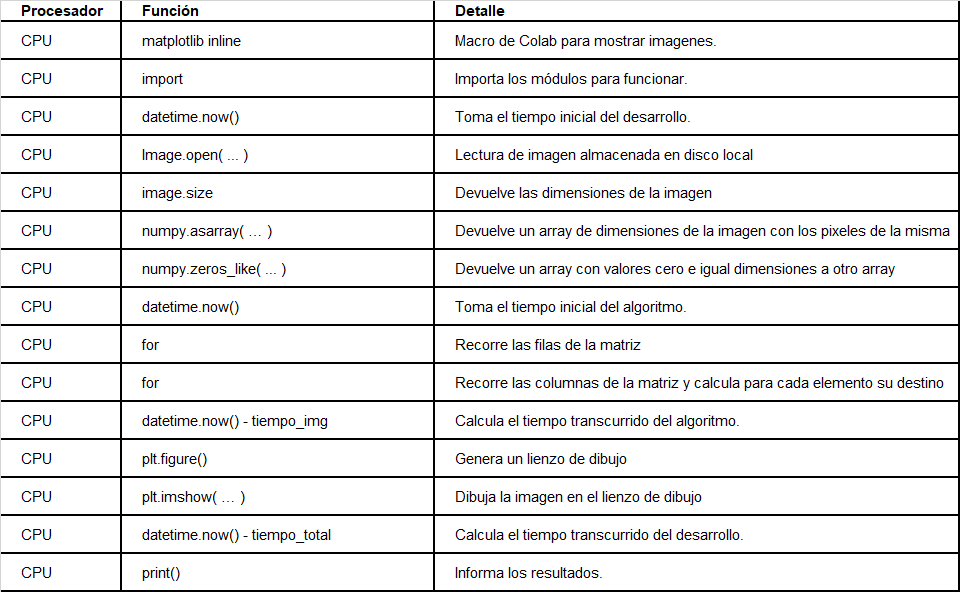

### 4.2. Versión GPU
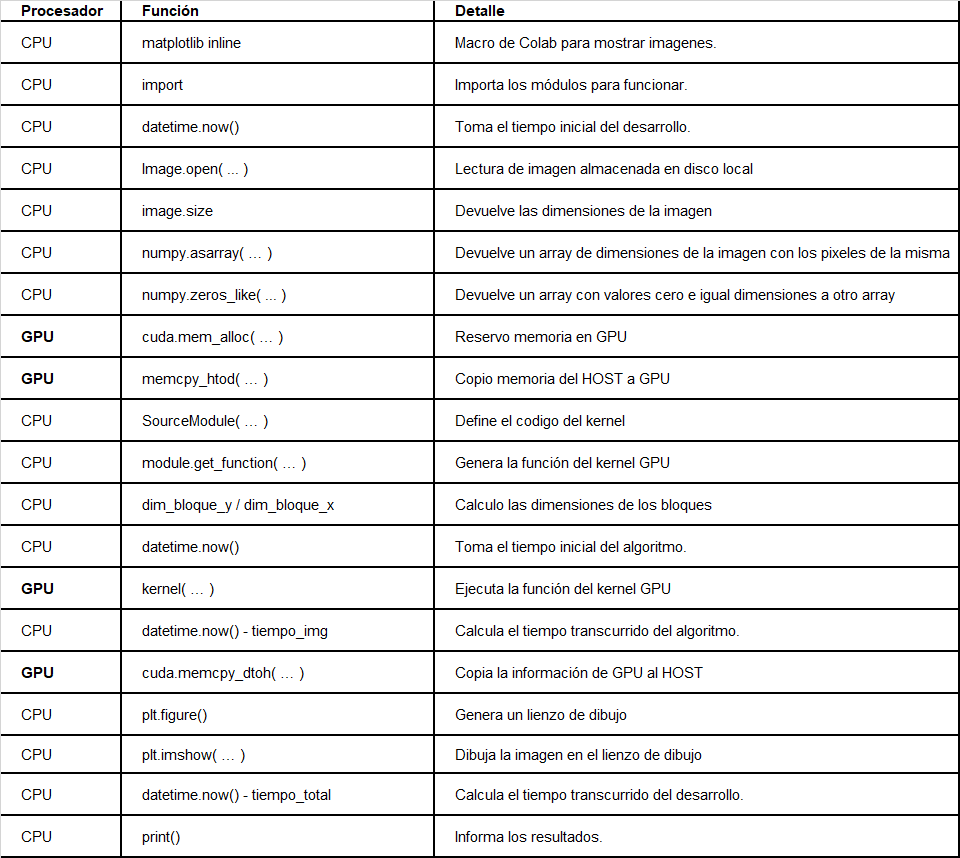

# 5. Conclusión
Podes notar de los resultados de rendimiento como el algoritmo GPU es totalmente superior en cuestiones de tiempo con respecto al CPU, siendo alrevés si hablamos de los desarrollos completos. 
Esto sucede ya que el reducido tiempo de calculo del algoritmo GPU no compensa la enorme carga generada por la gestión de GPU. Es por esto que concluyo que no vale la pena generar un algoritmo GPU siendo que este no es tan sencillo como el algoritmo en CPU.

De este algortimo se puede comprender como es el tratamiento de imagenes. Entendiendo como funciona la matriz, puede aplicarse sobre ella una infinidad de modificaciones o combinaciones con otras imagenes de manera muy sencilla.

Este algoritmo podría mejorarse si se almacena la imagen rotada sobre la misma matriz donde haya guardada la original.

# 6. Bibliografía

*   Python basico: [Github](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb)
*   Programacion paralela y distribuida: [SODIUM](http://so-unlam.com.ar/material-clase/HPC/Programación%20Paralela%20y%20Distribuida.pdf)
*   Introducción a Google Colab: [Github](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/google_colab_tutorial.pdf)
*   Documentación Matplotlib: [Matplotlib.org](https://matplotlib.org/api/pyplot_summary.html)
*   Procesamiento de imágenes: [Monografias](https://www.monografias.com/trabajos108/procesamiento-imagenes-traslacion-escala-rotacion-inclinacion/procesamiento-imagenes-traslacion-escala-rotacion-inclinacion.shtml)